# Step 0 Run useful functions for CLIENT

In [54]:
def server_chk():
    from openai import OpenAI
    # Set OpenAI's API key and API base to use vLLM's API server.
    openai_api_key = "EMPTY"
    openai_api_base = "http://localhost:8000/v1"
    client = OpenAI(
        api_key=openai_api_key,
        base_url=openai_api_base,
    )
    chat_response = client.chat.completions.create(
    model="RedHatAI/Llama-3.1-8B-Instruct",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": "Tell me a joke."},
        ],
        max_tokens=100,
        temperature=0.0,
    )
    print("RESPONSE:\n %10s"%(chat_response.choices[0].message.content))

def run_bench(SRC_LOG, TGT_LOG, isl, osl, con_list, case):
    import subprocess
    log_labels = f'''
        #!/usr/bin/bash
        printf run,                     2>&1 | tee -a {TGT_LOG}
        printf prompts,                 2>&1 | tee -a {TGT_LOG}
        printf median_ttft,             2>&1 | tee -a {TGT_LOG}
        printf median_tpot,             2>&1 | tee -a {TGT_LOG}
        printf median_e2e,              2>&1 | tee -a {TGT_LOG}
        printf total_tps                2>&1 | tee -a {TGT_LOG}
        printf "\n"                     2>&1 | tee -a {TGT_LOG}
        '''
    subprocess.run(log_labels, shell=True, check=True)
    for concurrency in con_list:
        prompts = 4 * concurrency

        vllm_run = f'''
            #!/usr/bin/env bash
            VLLM_LOGGING_LEVEL=ERROR \
            python3 /app/vllm/benchmarks/benchmark_serving.py \
                --model RedHatAI/Llama-3.1-8B-Instruct \
                --dataset-name random \
                --random-input-len {isl} \
                --random-output-len {osl} \
                --num-prompts {prompts} \
                --max-concurrency {concurrency} \
                --ignore-eos \
                --percentile-metrics ttft,tpot,e2el \
                2>&1 | tee {SRC_LOG}
            '''
        log_post_process = f'''
            #!/usr/bin/bash
            bash ./rpt_sum.sh {SRC_LOG} {TGT_LOG} {case}
            '''
        subprocess.run(vllm_run, shell=True, check=True)
        subprocess.run(log_post_process, shell=True, check=True)

def visualize_bench(logs):
    !pip install matplotlib -q
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    df_sum = pd.DataFrame()

    for log in logs:
        df_log = pd.read_csv(log, sep=',')
        print(df_log)
        df_sum = pd.concat([df_sum, df_log])

    fig, axes = plt.subplots(figsize=(16,8),nrows=1, ncols=3)

    df_sum_pivot=df_sum.pivot(index='prompts', columns='run', values='median_ttft')
    df_sum_pivot.plot.bar(rot=0, title='median_ttft (ms), lower is better', ax=axes[0])

    df_sum_pivot=df_sum.pivot(index='prompts', columns='run', values='median_tpot')
    df_sum_pivot.plot.bar(rot=0, title='median_tpot (ms), lower is better', ax=axes[1])

    ax = plt.gca() 
    ax.set_facecolor("pink")
    df_sum_pivot=df_sum.pivot(index='prompts', columns='run', values='total_tps')
    df_sum_pivot.plot.bar(rot=0, title='total_tps (tok/sec), higher is better', ax=axes[2])

# STEP 1 vLLM v0 Performance Benchmark

From vLLM server, you should see these messages first. The execute the followings

<span style="color:red"> *INFO:     Started server process [210]*</span>

<span style="color:red"> *INFO:     Waiting for application startup.*</span>

<span style="color:red"> *INFO:     Application startup complete.*</span>

In [34]:
# 1-1)  When vLLM server is ready, check the answer of "Tell me a joke"
server_chk()

RESPONSE:
 A man walked into a library and asked the librarian, "Do you have any books on Pavlov's dogs and Schrödinger's cat?" 

The librarian replied, "It rings a bell, but I'm not sure if it's here or not."


In [45]:
# 1-2) Run Benchmark: input_len/output_len = 1024/1024, concurrency = 32 and 64
!rm v0_summary.log

SRC_LOG="v0.log"
TGT_LOG="v0_summary.log"
case="v0"
run_bench(SRC_LOG, TGT_LOG, 1024, 1024, [32, 64], case)

rm: cannot remove 'v0_summary.log': No such file or directory
run,prompts,median_ttft,median_tpot,median_e2e,total_tps
Namespace(backend='vllm', base_url=None, host='127.0.0.1', port=8000, endpoint='/v1/completions', dataset_name='random', dataset_path=None, max_concurrency=32, model='RedHatAI/Llama-3.1-8B-Instruct', tokenizer=None, use_beam_search=False, num_prompts=128, logprobs=None, request_rate=inf, burstiness=1.0, seed=0, trust_remote_code=False, disable_tqdm=False, profile=False, save_result=False, save_detailed=False, append_result=False, metadata=None, result_dir=None, result_filename=None, ignore_eos=True, percentile_metrics='ttft,tpot,e2el', metric_percentiles='99', goodput=None, sonnet_input_len=550, sonnet_output_len=150, sonnet_prefix_len=200, sharegpt_output_len=None, random_input_len=1024, random_output_len=1024, random_range_ratio=0.0, random_prefix_len=0, hf_subset=None, hf_split=None, hf_output_len=None, top_p=None, top_k=None, min_p=None, temperature=None, tokenizer

## Run Benchmark: input_len/output_len = 1024/1024, concurrency = 32 and 64

  run  prompts  median_ttft  median_tpot  median_e2e  total_tps
0  v0      128       737.94         9.90    10850.57    6014.45
1  v0      256      1952.75        13.64    15824.27    8284.57


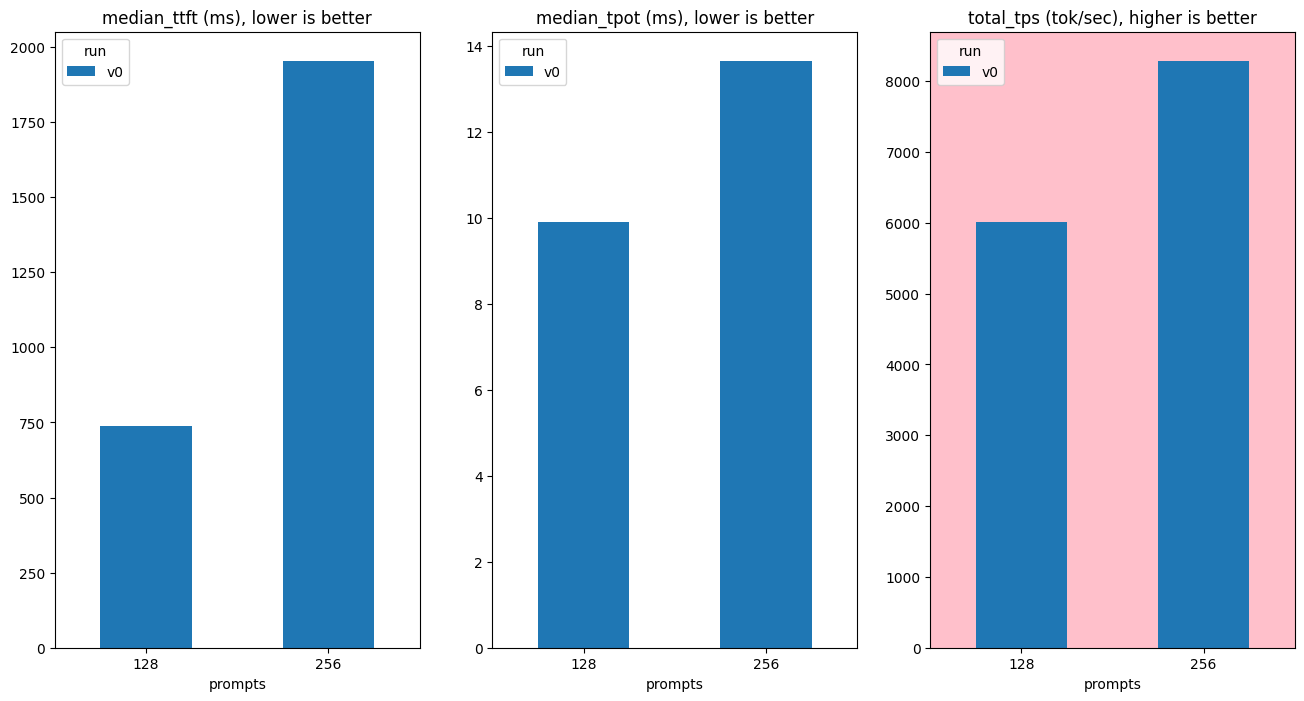

In [46]:
# 1-3) Visualize Benchmarks
logs = [
    "v0_summary.log",
    ]
visualize_bench(logs)

# STEP 2 vLLM v1 Performance Benchmark

From vLLM server, you should see these messages first. The execute the followings

<span style="color:red"> *INFO:     Started server process [210]*</span>

<span style="color:red"> *INFO:     Waiting for application startup.*</span>

<span style="color:red"> *INFO:     Application startup complete.*</span>

In [42]:
# 2-1) When vLLM server is ready, check the answer of "Tell me a joke"
server_chk()

RESPONSE:
 A man walked into a library and asked the librarian, "Do you have any books on Pavlov's dogs and Schrödinger's cat?" 

The librarian replied, "It rings a bell, but I'm not sure if it's here or not."


In [56]:
# 2-2) Run Benchmark: input_len/output_len = 1024/1024, concurrency = 32 and 64
!rm v1_summary.log

SRC_LOG="v1.log"
TGT_LOG="v1_summary.log"
case="v1"
run_bench(SRC_LOG, TGT_LOG, 1024, 1024, [32, 64], case)

rm: cannot remove 'v1_summary.log': No such file or directory
run,prompts,median_ttft,median_tpot,median_e2e,total_tps
Namespace(backend='vllm', base_url=None, host='127.0.0.1', port=8000, endpoint='/v1/completions', dataset_name='random', dataset_path=None, max_concurrency=32, model='RedHatAI/Llama-3.1-8B-Instruct', tokenizer=None, use_beam_search=False, num_prompts=128, logprobs=None, request_rate=inf, burstiness=1.0, seed=0, trust_remote_code=False, disable_tqdm=False, profile=False, save_result=False, save_detailed=False, append_result=False, metadata=None, result_dir=None, result_filename=None, ignore_eos=True, percentile_metrics='ttft,tpot,e2el', metric_percentiles='99', goodput=None, sonnet_input_len=550, sonnet_output_len=150, sonnet_prefix_len=200, sharegpt_output_len=None, random_input_len=1024, random_output_len=1024, random_range_ratio=0.0, random_prefix_len=0, hf_subset=None, hf_split=None, hf_output_len=None, top_p=None, top_k=None, min_p=None, temperature=None, tokenizer

  run  prompts  median_ttft  median_tpot  median_e2e  total_tps
0  v0      128       737.94         9.90    10850.57    6014.45
1  v0      256      1952.75        13.64    15824.27    8284.57
  run  prompts  median_ttft  median_tpot  median_e2e  total_tps
0  v1      128       453.17         9.33    10014.42    6536.78
1  v1      256       518.65        13.42    14271.35    9185.29


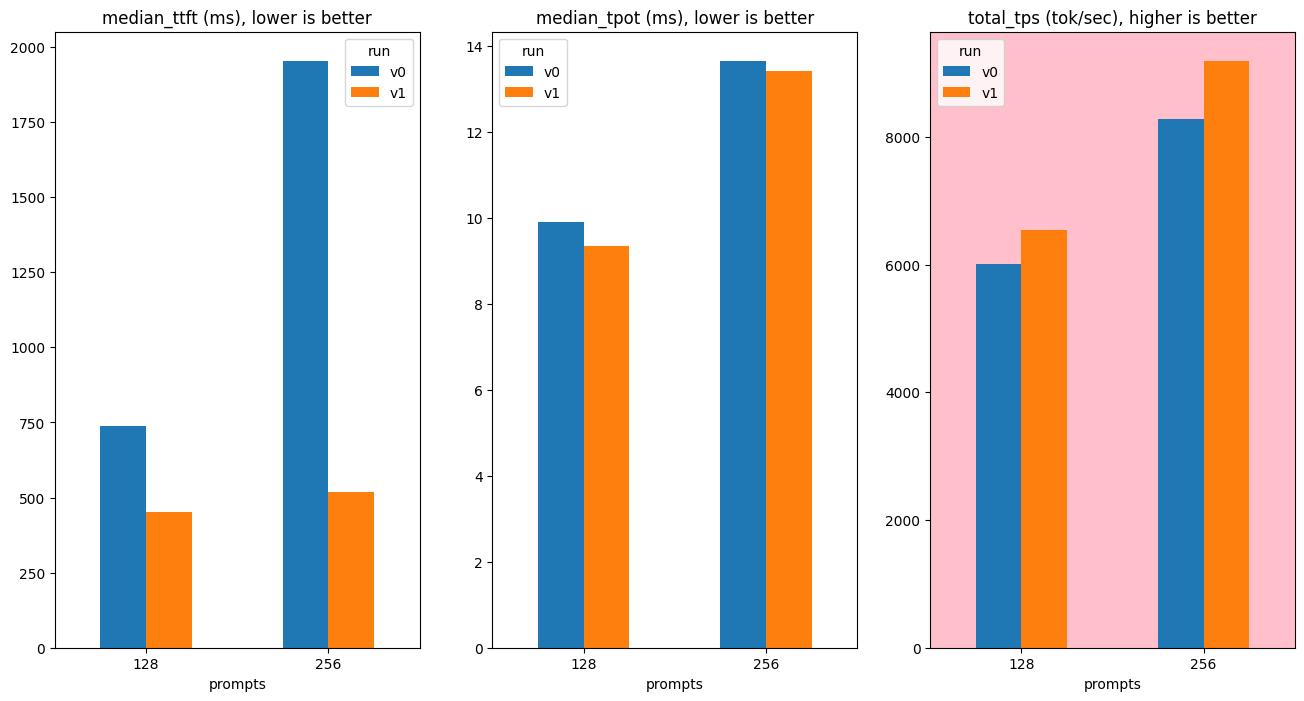

In [57]:
# 2-3) Visualize Benchmarks
logs = [
    "v0_summary.log",
    "v1_summary.log",
    ]
visualize_bench(logs)

# STEP 3 vLLM v1 + Prefix Caching Performance Benchmark

From vLLM server, you should see these messages first. The execute the followings

<span style="color:red"> *INFO:     Started server process [210]*</span>

<span style="color:red"> *INFO:     Waiting for application startup.*</span>

<span style="color:red"> *INFO:     Application startup complete.*</span>

In [58]:
# 3-1) When vLLM server is ready, check the answer of "Tell me a joke"
server_chk()

RESPONSE:
 A man walked into a library and asked the librarian, "Do you have any books on Pavlov's dogs and Schrödinger's cat?" 

The librarian replied, "It rings a bell, but I'm not sure if it's here or not."


In [60]:
# 3-2) Run Benchmark: input_len/output_len = 1024/1024, concurrency = 32 and 64
!rm v1PC_summary.log

SRC_LOG="v1PC.log"
TGT_LOG="v1PC_summary.log"
case="v1PC"
run_bench(SRC_LOG, TGT_LOG, 1024, 1024, [32, 64], case)

run,prompts,median_ttft,median_tpot,median_e2e,total_tps
Namespace(backend='vllm', base_url=None, host='127.0.0.1', port=8000, endpoint='/v1/completions', dataset_name='random', dataset_path=None, max_concurrency=32, model='RedHatAI/Llama-3.1-8B-Instruct', tokenizer=None, use_beam_search=False, num_prompts=128, logprobs=None, request_rate=inf, burstiness=1.0, seed=0, trust_remote_code=False, disable_tqdm=False, profile=False, save_result=False, save_detailed=False, append_result=False, metadata=None, result_dir=None, result_filename=None, ignore_eos=True, percentile_metrics='ttft,tpot,e2el', metric_percentiles='99', goodput=None, sonnet_input_len=550, sonnet_output_len=150, sonnet_prefix_len=200, sharegpt_output_len=None, random_input_len=1024, random_output_len=1024, random_range_ratio=0.0, random_prefix_len=0, hf_subset=None, hf_split=None, hf_output_len=None, top_p=None, top_k=None, min_p=None, temperature=None, tokenizer_mode='auto', served_model_name=None, lora_modules=None)
Start

In [ ]:
# 3-3) Run Benchmark one more time to use prefix-cache: input_len/output_len = 1024/1024, concurrency = 32 and 64
!rm v1PC_summary.log

SRC_LOG="v1PC.log"
TGT_LOG="v1PC_summary.log"
case="v1PC"
run_bench(SRC_LOG, TGT_LOG, 1024, 1024, [32, 64], case)

run,prompts,median_ttft,median_tpot,median_e2e,total_tps
Namespace(backend='vllm', base_url=None, host='127.0.0.1', port=8000, endpoint='/v1/completions', dataset_name='random', dataset_path=None, max_concurrency=32, model='RedHatAI/Llama-3.1-8B-Instruct', tokenizer=None, use_beam_search=False, num_prompts=128, logprobs=None, request_rate=inf, burstiness=1.0, seed=0, trust_remote_code=False, disable_tqdm=False, profile=False, save_result=False, save_detailed=False, append_result=False, metadata=None, result_dir=None, result_filename=None, ignore_eos=True, percentile_metrics='ttft,tpot,e2el', metric_percentiles='99', goodput=None, sonnet_input_len=550, sonnet_output_len=150, sonnet_prefix_len=200, sharegpt_output_len=None, random_input_len=1024, random_output_len=1024, random_range_ratio=0.0, random_prefix_len=0, hf_subset=None, hf_split=None, hf_output_len=None, top_p=None, top_k=None, min_p=None, temperature=None, tokenizer_mode='auto', served_model_name=None, lora_modules=None)
Start

  run  prompts  median_ttft  median_tpot  median_e2e  total_tps
0  v0      128       737.94         9.90    10850.57    6014.45
1  v0      256      1952.75        13.64    15824.27    8284.57
  run  prompts  median_ttft  median_tpot  median_e2e  total_tps
0  v1      128       453.17         9.33    10014.42    6536.78
1  v1      256       518.65        13.42    14271.35    9185.29
    run  prompts  median_ttft  median_tpot  median_e2e  total_tps
0  v1PC      128        51.37         8.88     9140.06    7135.68
1  v1PC      256        63.84        12.08    12447.14   10517.26


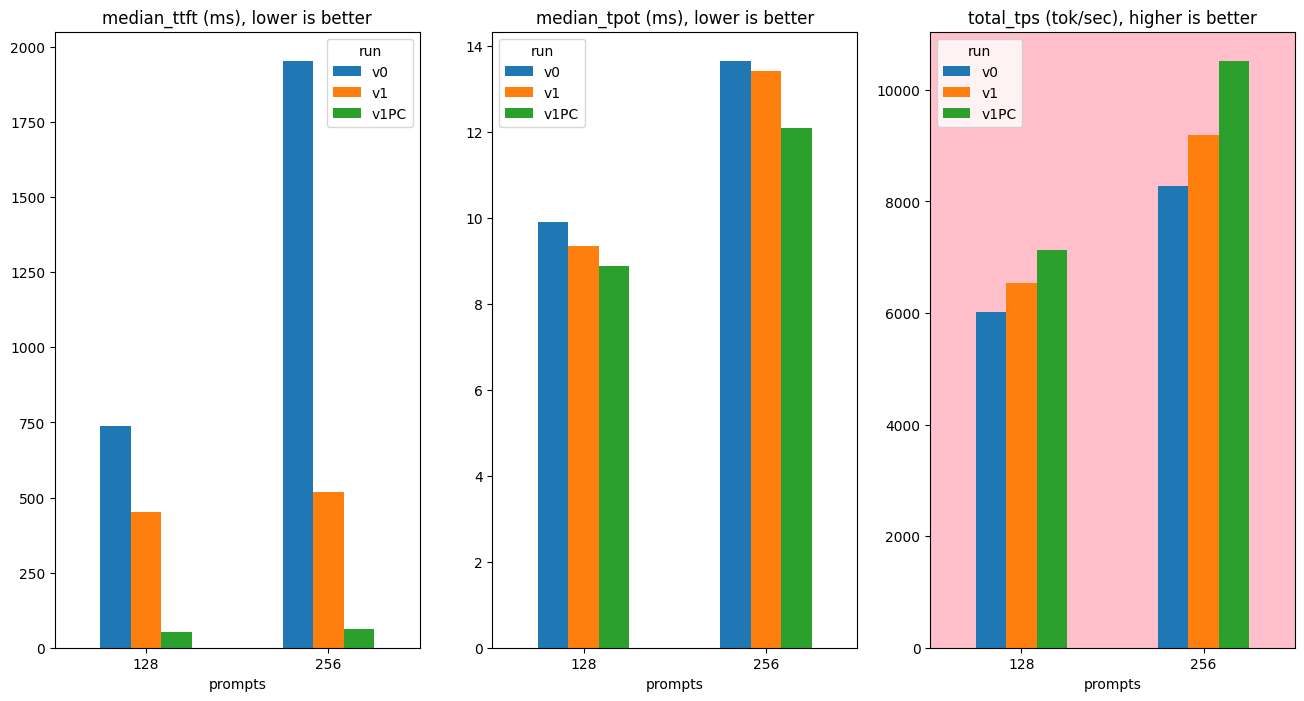

In [61]:
# 3-4) Visualize Benchmarks
logs = [
    "v0_summary.log",
    "v1_summary.log",
    "v1PC_summary.log",
    ]
visualize_bench(logs)